### Task: Detect and Segment Potholes on the Road

The goal of this task is to detect potholes on the road using image processing techniques and segment them for further analysis. The following steps outline the approach to achieve this:

1. **Image Acquisition**  
   Collect images of road surfaces where potholes may be present. These images can be captured using a camera mounted on a vehicle or through satellite imagery.

2. **Preprocessing**  
   Apply necessary preprocessing steps to enhance the features of the road surface, such as:
   - **Grayscale Conversion**: Convert the image to grayscale to simplify the processing.
   - **Noise Removal**: Use filters to reduce noise and make the features more prominent (e.g., Gaussian blur).

3. **Segmentation**  
   Segment the potholes in the image by distinguishing them from the surrounding road surface. This can be achieved through techniques like:
   - **Thresholding**: Apply contrast-based thresholding to separate potential potholes from the background.
   - **Edge Detection**: Use algorithms like Canny edge detection to identify edges where potholes are located.
   - **Texture Analysis**: Use homogeneity or contrast-based texture features to identify pothole regions.

4. **Contour Detection**  
   Use contour detection to identify the boundaries of segmented regions. This helps to define the exact shape and size of each pothole.

5. **Bounding Boxes**  
   Draw bounding boxes around detected potholes to visualize their locations on the road.

6. **Post-Processing**  
   Refine the segmentation results by removing small or irrelevant regions that do not represent potholes. Additionally, apply morphological operations to smooth and enhance the results.

7. **Display Results**  
   Overlay the segmented potholes and bounding boxes on the original image to visualize the detected areas.

By performing these steps, the potholes can be effectively detected and segmented for further analysis, such as calculating their size, location, and severity for road maintenance planning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io, transform
from skimage.color import rgb2gray
from typing import Tuple, Optional, List, Dict
from scipy import ndimage, signal
from skimage.filters.rank import entropy
from skimage.morphology import closing, opening, square, footprint_rectangle, disk
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
from skimage.feature import graycomatrix, graycoprops
from skimage.util.shape import view_as_windows
from scipy import ndimage

In [2]:
path = "/content/img-483_jpg.rf.f6a3c845bd1d570af65d49dca73bc342.jpg"
img = io.imread(path)

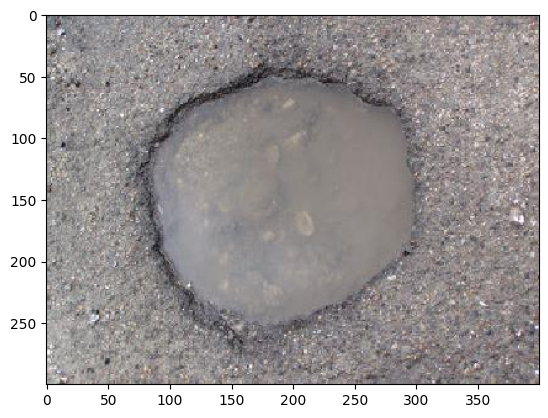

In [ ]:
plt.imshow(img)
plt.show()

In [3]:
# Convert the image to grayscale and convert to uint8
img_gray = rgb2gray(img)
img_gray = (img_gray * 255).astype(np.uint8)

# Apply GaussianBlur to reduce noise
blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

# Apply entropy
img_entropy = entropy(blurred, disk(5))

# Initialize matrices to store texture properties
img_contrast = np.zeros(img_entropy.shape)
img_correlation = np.zeros(img_entropy.shape)
img_energy = np.zeros(img_entropy.shape)
img_homogeneity = np.zeros(img_entropy.shape)

In [4]:
# Define the parameters for texture analysis
distances = [1]
angles = [0]
properties = ['contrast', 'correlation', 'energy', 'homogeneity']
window_size = 9

# Iterate through image slices to calculate texture properties
for i in tqdm(range(0, img_entropy.shape[0]-window_size)):
  for j in range(0, img_entropy.shape[1]-window_size):

    # Extract a window from the grayscale image
    window = blurred[i:i + window_size, j:j + window_size]

    # Calculate the gray-level co-occurrence matrix (GLCM) for the window
    glcm = graycomatrix(window,
                        distances=distances,
                        angles=angles,
                        symmetric=True,
                        normed=True)

    # Calculate and store texture properties in the corresponding matrices
    feats = np.hstack([graycoprops(glcm, prop).ravel() for prop in properties])
    img_contrast[i, j] = feats[0]
    img_correlation[i, j] = feats[1]
    img_energy[i, j] = feats[2]
    img_homogeneity[i, j] = feats[3]

  0%|          | 0/291 [00:00<?, ?it/s]

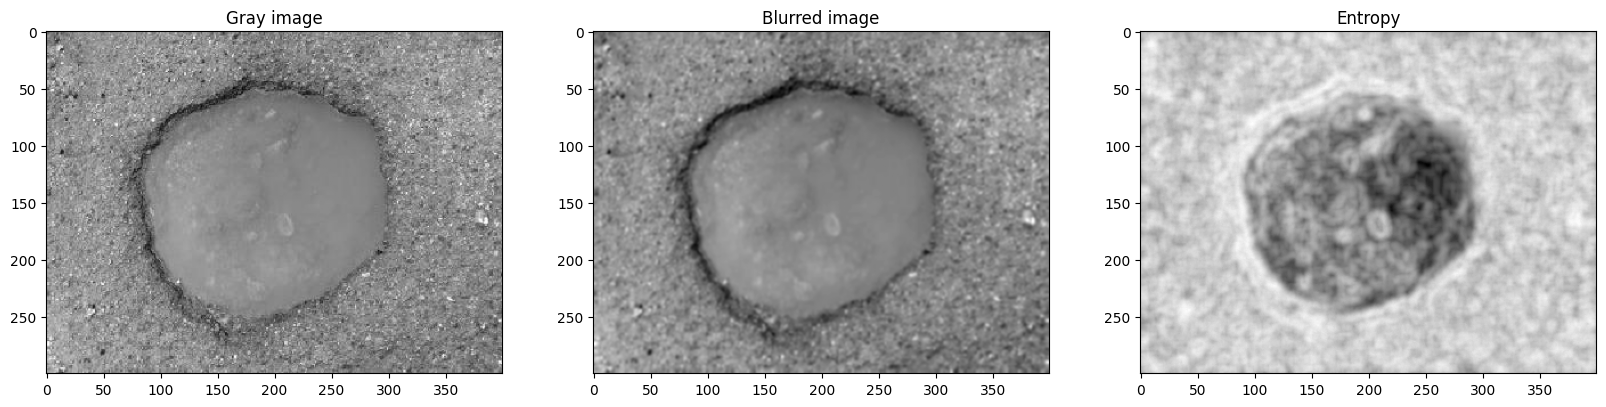

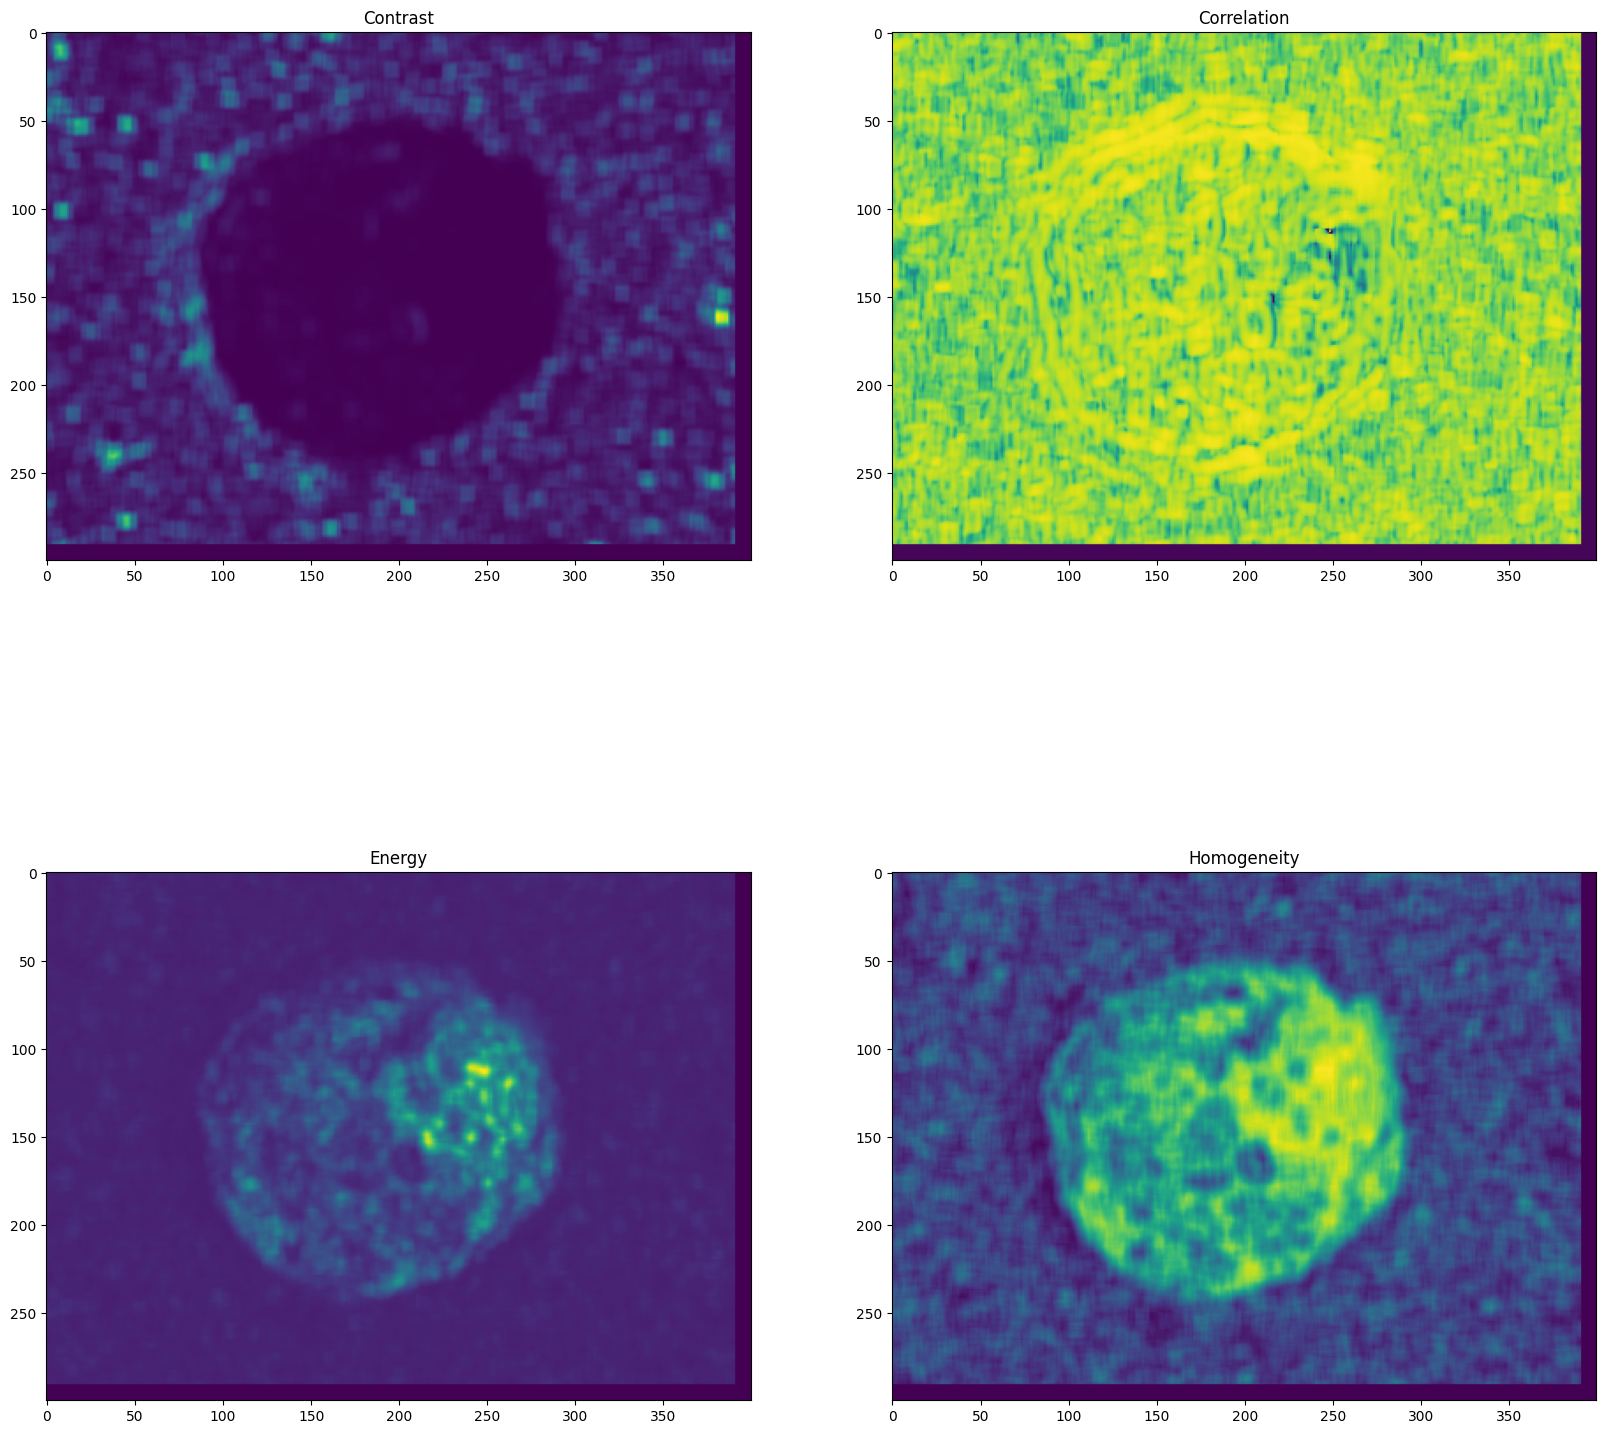

In [ ]:
# Vizualization
plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(img_gray, cmap='gray')
plt.title("Gray image")

plt.subplot(132)
plt.imshow(blurred, cmap='gray')
plt.title("Blurred image")

plt.subplot(133)
plt.imshow(img_entropy, cmap='gray')
plt.title("Entropy")

plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.imshow(img_contrast)
plt.title('Contrast')

plt.subplot(222)
plt.imshow(img_correlation)
plt.title('Correlation')

plt.subplot(223)
plt.imshow(img_energy)
plt.title('Energy')

plt.subplot(224)
plt.imshow(img_homogeneity)
plt.title('Homogeneity')
plt.show()

Text(0.5, 1.0, 'Plot of dispersion')

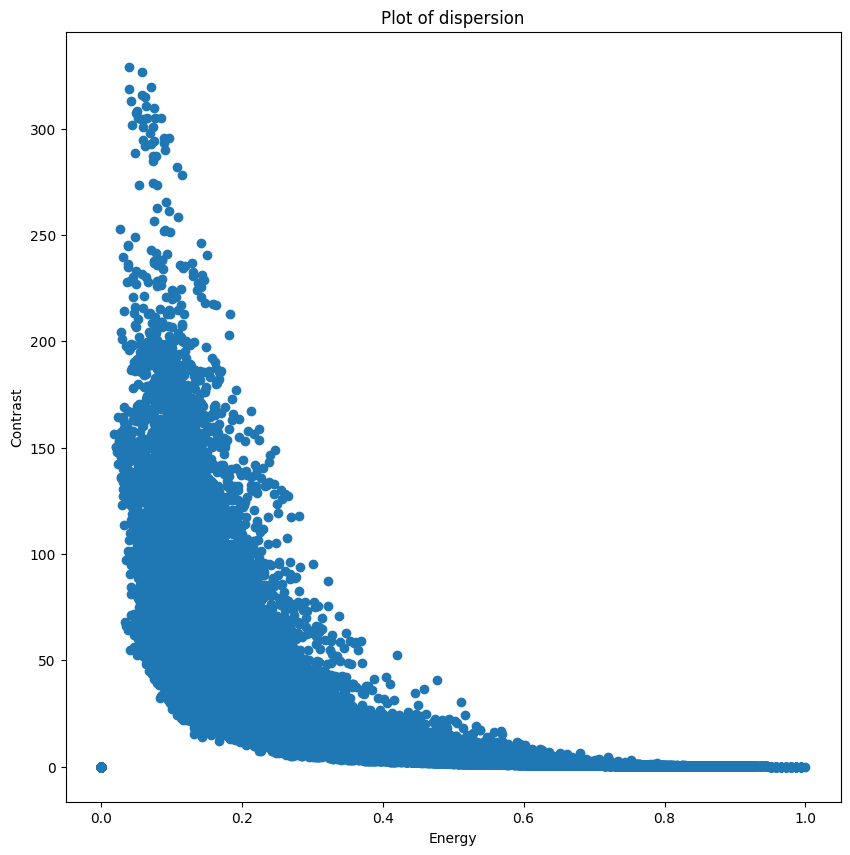

In [ ]:
# Create a scatter plot to visualize the energy and contrast of the image
plt.figure(figsize=(10, 10))
plt.scatter(img_homogeneity.ravel(), img_contrast.ravel())
plt.xlabel('Energy')
plt.ylabel('Contrast')
plt.title('Plot of dispersion')

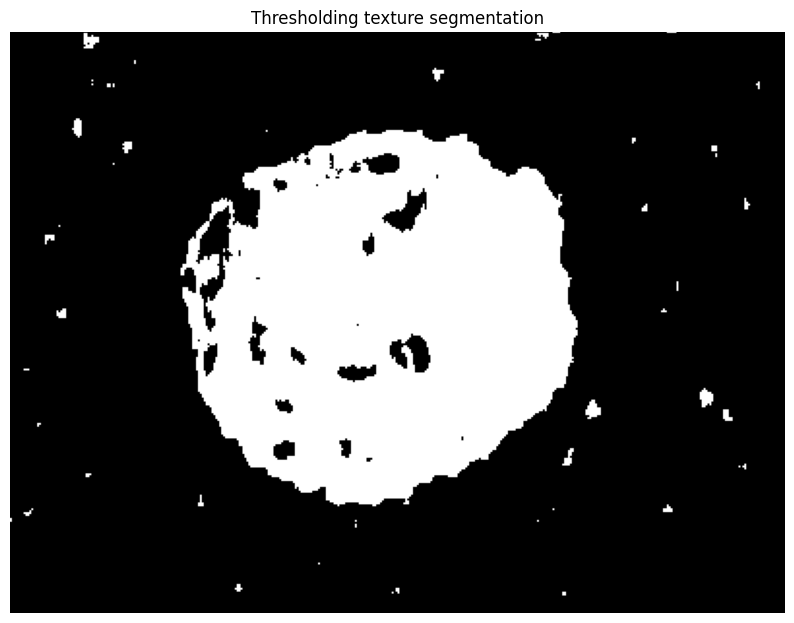

In [5]:
# Use Thresholding for texture segmentation
segmented_image = np.logical_and(img_homogeneity>0.37, img_contrast<10)

# Display the segmented image
plt.figure(figsize=(10, 10))
plt.title('Thresholding texture segmentation')
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')
plt.show()

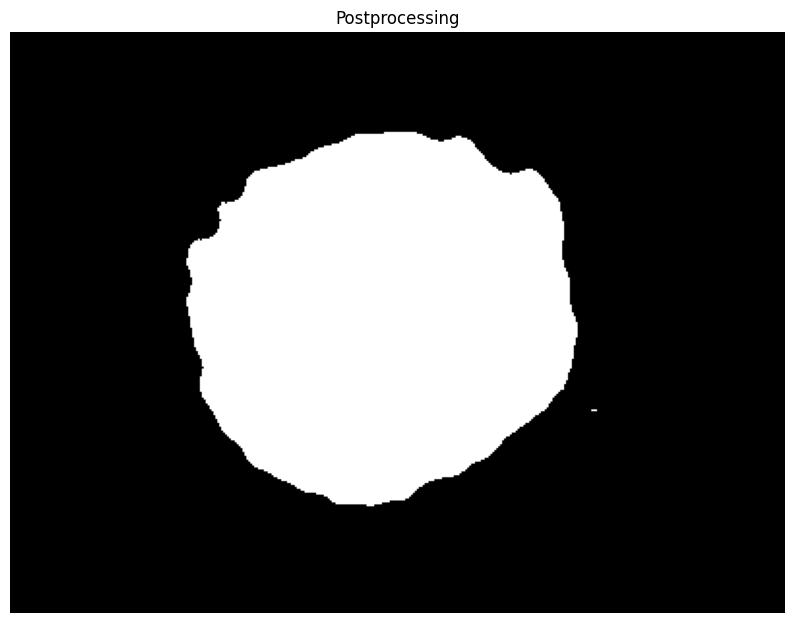

In [6]:
# Postprocessing (using median_filter, closing)
postprocessed_image = ndimage.median_filter(segmented_image, size=10)
postprocessed_image = closing(postprocessed_image, disk(10))

# Vizualizate the result
plt.figure(figsize=(10, 10))
plt.title('Postprocessing')
plt.imshow(postprocessed_image, cmap='gray')
plt.axis('off')
plt.show()

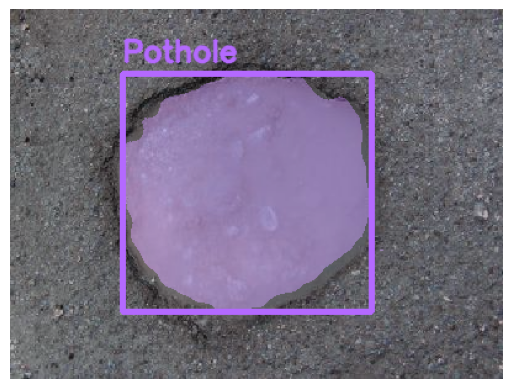

In [7]:
# Binarize if the image is not 0-255
postprocessed_image = (postprocessed_image > 0).astype(np.uint8) * 255

# Convert to 3-channel for overlaying
postprocessed_image_3ch = cv2.cvtColor(postprocessed_image, cv2.COLOR_GRAY2BGR)

# Change the size if the sizes don't match
postprocessed_image_3ch = cv2.resize(postprocessed_image_3ch, (img.shape[1], img.shape[0]))

# Replace the white color with pink (255, 105, 180)
pink_mask = np.where(postprocessed_image_3ch == 255, (255, 105, 180), postprocessed_image_3ch).astype(np.uint8)

# Semi-transparent overlay of segmented area
overlay = cv2.addWeighted(img, 0.7, pink_mask, 0.3, 0)

# Looking for the contours of the pothole
contours, _ = cv2.findContours(postprocessed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Remove small contours
min_contour_area = 1000
filtered_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

# Draw a border on the final image (overlay)
for contour in filtered_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(overlay, (x, y), (x + w, y + h), (255, 105, 180), 3)  # Красная рамка

    # Add a "Pothole" caption above the frame
    text_x = x  # X position coincides with the left edge of the frame
    text_y = max(y - 10, 20)  # Raise the text above the frame, but keep it within the image boundaries
    cv2.putText(
        overlay, "Pothole", (text_x, text_y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 105, 180), 2, cv2.LINE_AA
    )

# Result display
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()